# Analysis of HIV Treatment Effects - Full Compliance Dataset

This notebook explores the HIV treatment dataset with full compliance (where all treated patients receive the treatment and no control patients receive it). We'll:

1. Load and explore the dataset
2. Visualize key relationships and distributions
3. Apply simple statistical test to estimate the treatment effect with and without covariate
4. Estimate the causal structure and use this to estimate the effect
5. Compare the different estimates to the true effect

In [205]:
# Import libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from dowhy import CausalModel
from scipy import stats
import warnings

In [206]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = [10, 6]
warnings.filterwarnings('ignore')

# increase the default print out length
pd.set_option('display.max_columns', None)

## Load and Explore the Dataset

In [207]:
# Load the dataset
df_experiments = pd.read_pickle(os.path.join('data', 'hiv_full_compliance.pkl'))

In [208]:
# Separate the first experiment for exploring the data
df = df_experiments[df_experiments['experiment_number'] == 0].copy()

In [209]:
# How the data looks
df.head()

,uninfected_t1,infected_t1,uninfected_t2,infected_t2,free_virus,immune_response,enrolled,treatment,outcome,true_effect,experiment_number
0,168013.251186,10489.816212,5.803810,45.168350,56416.289700,27.226979,1,1,46.859652,1.206532,0
1,168354.340012,10364.747125,5.874707,45.167844,55740.078929,27.125079,0,0,45.656999,1.185633,0
2,166845.707563,11993.112619,5.081023,45.240082,64492.721511,26.118460,0,0,45.606440,1.356003,0
3,168625.302731,10280.627778,5.923619,45.168924,55284.586066,26.585281,0,0,45.659628,1.170306,0
4,167492.055491,10686.562443,5.695729,45.169672,57480.010583,27.183053,1,1,46.886269,1.239227,0


In [210]:
# Summary statistics
df.describe()

,uninfected_t1,infected_t1,uninfected_t2,infected_t2,free_virus,immune_response,enrolled,treatment,outcome,true_effect,experiment_number
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0
mean,167943.321589,10652.055194,5.723669,45.178258,57286.982074,26.823750,0.485000,0.485000,46.237668,1.221078,0.0
std,834.474297,390.530883,0.200315,0.018037,2104.122328,0.549225,0.501029,0.501029,0.610670,0.053871,0.0
min,166201.508866,10190.262391,5.057698,45.167320,54795.165701,24.804012,0.000000,0.000000,45.604472,1.092792,0.0
25%,167459.867216,10387.878652,5.641262,45.168362,55865.273468,26.574385,0.000000,0.000000,45.650950,1.183543,0.0
50%,168011.839373,10528.174774,5.787864,45.169968,56599.607279,26.852652,0.000000,0.000000,45.661737,1.208955,0.0
75%,168423.733212,10789.199521,5.861432,45.177762,58033.843871,27.211083,1.000000,1.000000,46.859780,1.247902,0.0
max,171253.215280,12053.103317,5.977139,45.251788,64806.563361,27.670137,1.000000,1.000000,46.975572,1.366468,0.0


In [211]:
# define the covariates for easy reference
covariates = [
    'uninfected_t1',
    'infected_t1',
    'uninfected_t2',
    'infected_t2',
    'free_virus',
    'immune_response'
]

## Visual Assessment

It is clear from simple visualizations that the treatment effect is significant as the groups are clearly distinquishable from the outcome metric alone. The is no overlap between the groups on the outcome measure

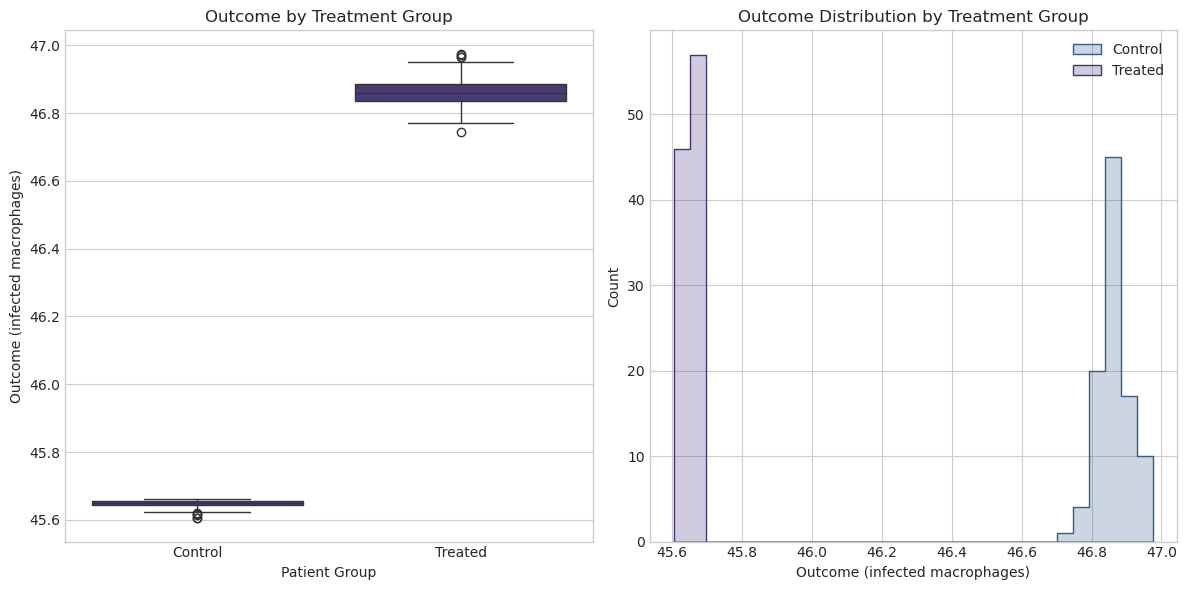

In [212]:
# Outcomes are clearly different between the two groups
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='treatment', y='outcome', data=df)
plt.xticks([0, 1], ['Control', 'Treated'])
plt.title('Outcome by Treatment Group')
plt.xlabel('Patient Group')
plt.ylabel('Outcome (infected macrophages)')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='outcome', hue='treatment', element='step', common_norm=False, bins=30)
plt.title('Outcome Distribution by Treatment Group')
plt.xlabel('Outcome (infected macrophages)')
plt.legend(['Control', 'Treated'])

plt.tight_layout()
plt.show()

If we look at the relationship between the outcome and covariates, we see that the general trend has wide error margins because the treatments groups differ so much from each other. The relation of the covariates on the outcome seems to differ between the treatment groups with sign of the coefficient flipping from one group to another. This means that the covariates by themselves are not as informative as with an interaction with the treatment.

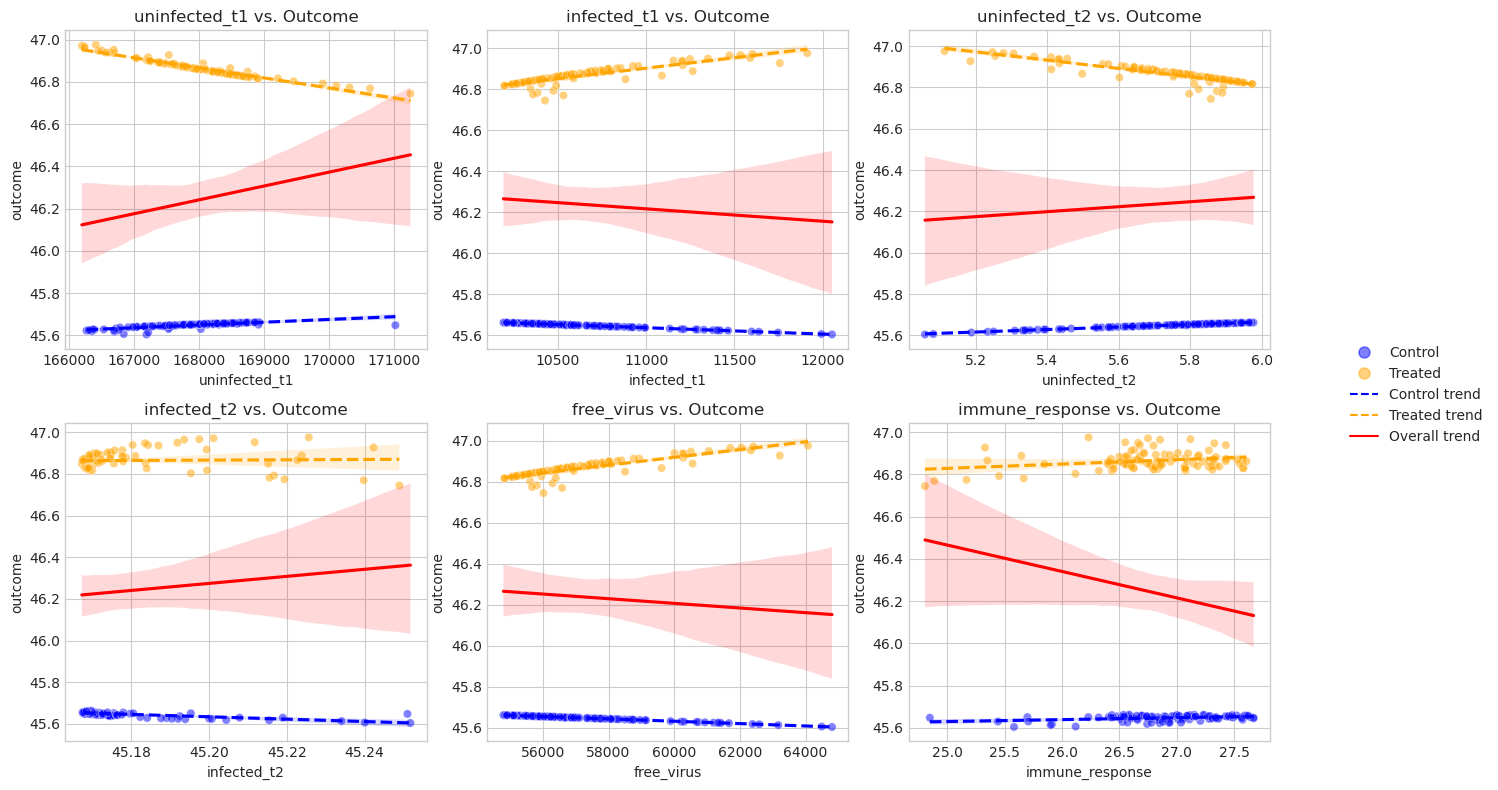

In [213]:
fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.flatten()

# Create lines for legend - we'll use these later
lines = []
labels = []

for i, covariate in enumerate(covariates):
    # Create scatter plot with alpha for points
    sns.scatterplot(x=covariate, y='outcome', hue='treatment', data=df, ax=axes[i],
                    alpha=0.5, palette={0: 'blue', 1: 'orange'}, legend=False)

    # Add regression line for each treatment group
    control_line = sns.regplot(x=covariate, y='outcome', data=df[df['treatment'] == 0],
                ax=axes[i], scatter=False, line_kws={'linestyle':'--', 'color': 'blue'}, label='_nolegend_')
    treated_line = sns.regplot(x=covariate, y='outcome', data=df[df['treatment'] == 1],
                ax=axes[i], scatter=False, line_kws={'linestyle':'--', 'color': 'orange'}, label='_nolegend_')

    # Add single regression line for all data in red
    overall_line = sns.regplot(x=covariate, y='outcome', data=df, ax=axes[i],
                scatter=False, line_kws={'color': 'red'}, color='red', label='_nolegend_')

    axes[i].set_title(f'{covariate} vs. Outcome')

    # Save lines for the legend if this is the first iteration
    if i == 0:
        # Get lines and scatter points for the legend
        lines = [
            plt.Line2D([0], [0], color='blue', marker='o', linestyle='', markersize=8, alpha=0.5),
            plt.Line2D([0], [0], color='orange', marker='o', linestyle='', markersize=8, alpha=0.5),
            plt.Line2D([0], [0], color='blue', linestyle='--'),
            plt.Line2D([0], [0], color='orange', linestyle='--'),
            plt.Line2D([0], [0], color='red')
        ]
        labels = ['Control', 'Treated', 'Control trend', 'Treated trend', 'Overall trend']

plt.tight_layout()

# Add a legend to the right of the subplots
fig.subplots_adjust(right=0.85)  # Make room for the legend
fig.legend(lines, labels, loc='center right', bbox_to_anchor=(1.0, 0.5))

plt.show()

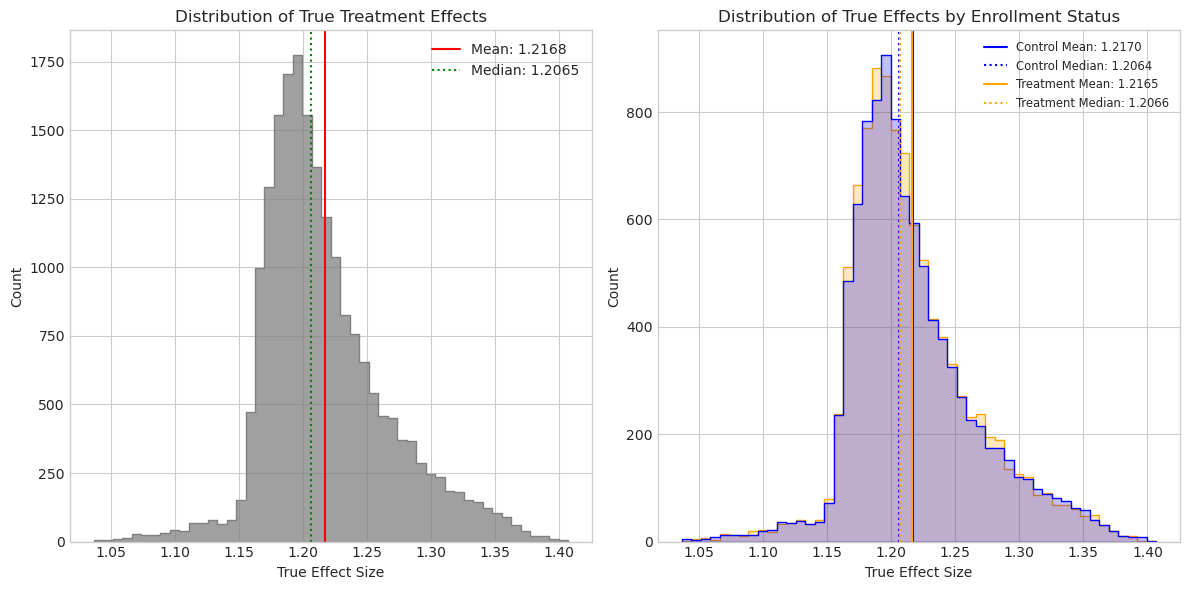

In [214]:
# Plot the distribution of true effects

bins = 50

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_experiments['true_effect'], element='step', bins=bins, color='gray')
plt.axvline(x=df_experiments['true_effect'].mean(), color='red', linestyle='-',
           label=f'Mean: {df_experiments["true_effect"].mean():.4f}')
plt.axvline(x=df_experiments['true_effect'].median(), color='green', linestyle=':',
           label=f'Median: {df_experiments["true_effect"].median():.4f}')
plt.title('Distribution of True Treatment Effects')
plt.xlabel('True Effect Size')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=df_experiments, x='true_effect', hue='enrolled', element='step', common_norm=False, bins=bins, palette={0: 'blue', 1: 'orange'})
plt.title('Distribution of True Effects by Enrollment Status')
plt.xlabel('True Effect Size')
plt.axvline(x=df_experiments[df_experiments['enrolled']==0]['true_effect'].mean(), color='blue', linestyle='-',
           label=f'Control Mean: {df_experiments[df_experiments["enrolled"]==0]["true_effect"].mean():.4f}')
plt.axvline(x=df_experiments[df_experiments['enrolled']==0]['true_effect'].median(), color='blue', linestyle=':',
           label=f'Control Median: {df_experiments[df_experiments["enrolled"]==0]["true_effect"].median():.4f}')
plt.axvline(x=df_experiments[df_experiments['enrolled']==1]['true_effect'].mean(), color='orange', linestyle='-',
           label=f'Treatment Mean: {df_experiments[df_experiments["enrolled"]==1]["true_effect"].mean():.4f}')
plt.axvline(x=df_experiments[df_experiments['enrolled']==1]['true_effect'].median(), color='orange', linestyle=':',
           label=f'Treatment Median: {df_experiments[df_experiments["enrolled"]==1]["true_effect"].median():.4f}')
plt.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

## Evaluating How Accurate Different Estimation Methods Are

If we try to evaluate the effect of the treatment with a t-test with and without the covariates, we notice two things. First, the p-values for the correlates are not significant. This is because accross the groups the impact of the covariates is clearly different so it is no surprise that the overall impact is non-significant. Second, the confidence intervals for the treatment impact (coefficient) get bigger in the t-test with covariates. This is not related to the fact that covariate coefficients are not significant, but to the fact that they are not correlated with the treatment. Even with highly predictive coefficients that treatment estimate would not budge much and the confidence intervals would get bigger. This is because with the random allocation, the correlates give no information about the treatment impact and as they add more freedom to the model (more moving parts) all the individual estimates get less certain and this includes the treatment effect.

In [215]:

# Analyze relationship between covariates, enrollment status and outcomes

# Linear regression predicting outcome with just enrollment status
enrollment_only_model = sm.OLS(df['outcome'], sm.add_constant(df['enrolled'])).fit()

print("MODEL 1: OUTCOME PREDICTED BY ENROLLMENT ONLY")
print(enrollment_only_model.summary().tables[1])

# Linear regression predicting outcome with covariates and enrollment
covariates_enrollment_formula = 'outcome ~ enrolled + ' + ' + '.join(covariates)
covariates_enrollment_model = smf.ols(covariates_enrollment_formula, data=df).fit()

print("MODEL 2: OUTCOME PREDICTED BY COVARIATES AND ENROLLMENT")
print(covariates_enrollment_model.summary().tables[1])

# Compare the models
print("COMPARISON OF MODELS")
print(f"R-squared (enrollment only): {enrollment_only_model.rsquared:.4f}")
print(f"R-squared (covariates + enrollment): {covariates_enrollment_model.rsquared:.4f}")

# Get enrollment coefficient and confidence interval from models
enroll_only_coef = enrollment_only_model.params['enrolled']
enroll_only_conf_int = enrollment_only_model.conf_int().loc['enrolled']

enrolled_coef = covariates_enrollment_model.params['enrolled']
enrolled_conf_int = covariates_enrollment_model.conf_int().loc['enrolled']

# Coefficients and confidence intervals comparison
print("\nENROLLMENT COEFFICIENTS:")
print(f"Coefficient, 95% CI, CI width (enrollment only): {enroll_only_coef:.4f}, [{enroll_only_conf_int[0]:.4f}, {enroll_only_conf_int[1]:.4f}], CI width: {enroll_only_conf_int[1] - enroll_only_conf_int[0]:.4f}")
print(f"Coefficient, 95% CI, CI width (covariates + enrollment): {enrolled_coef:.4f}, [{enrolled_conf_int[0]:.4f}, {enrolled_conf_int[1]:.4f}], CI width: {enrolled_conf_int[1] - enrolled_conf_int[0]:.4f}")


MODEL 1: OUTCOME PREDICTED BY ENROLLMENT ONLY
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.6473      0.003   1.45e+04      0.000      45.641      45.654
enrolled       1.2172      0.005    269.207      0.000       1.208       1.226
MODEL 2: OUTCOME PREDICTED BY COVARIATES AND ENROLLMENT
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         392.2715   1014.767      0.387      0.700   -1609.251    2393.794
enrolled            1.2218      0.004    307.799      0.000       1.214       1.230
uninfected_t1       0.0004      0.001      0.265      0.791      -0.002       0.003
infected_t1        -0.0474      0.199     -0.238      0.812      -0.440       0.345
uninfected_t2      -1.0832      3.907     -0.277      0.782      -8.790       

But hold on a bit! What we saw in the scatter plots above was that covariates have a clear relation to the outcome, but this is relationship is different between the treatment groups. Putting the covariates to model by themselves is not helpful, but what if we put the covariates with interactions with the treatment group. This should capture the differences in the relationship between the outcome and covariates by treatment group.

Indeed! This gives us something much more interesting. No almost all the terms are significant and all the interactions are significant. Looks like a great fit! But alas, there is a bit of problem. We are interested just in the enrolled variable coefficient and now became big and negative. Does this mean that actually the treatment was harmful. Not at all, the change here stems from the fact that with the interaction term the interpretation of the coefficient is now completely different. The coefficient are the change in the outcome when all the other model terms are held constant. With just the covariates and the enrollment this means that we can interpret the enrollment coefficient as the treatment impact, but with enrolment also baked into the interaction terms, no the coefficient means something like 'impact of treatment, when the interaction of the treatment with the covariates is kept constant', which is hard to wrap your mind around. This model looks good, but to extract the treatment impact we need to calculate the average treatment impact using the covariates from this model plugging in the data. This will gives us the average treatment effect. We have to do this as with the interaction there is no longer one single treatment effect that is the same for each patient.

In [216]:
# Linear regression with covariates, enrollment and interaction terms

interaction_terms = [f'enrolled:{cov}' for cov in covariates]
interaction_formula = covariates_enrollment_formula + ' + ' + ' + '.join(interaction_terms)
interaction_model = smf.ols(interaction_formula, data=df).fit()

print("MODEL 3: OUTCOME PREDICTED BY COVARIATES, ENROLLMENT AND INTERACTIONS")
print(interaction_model.summary().tables[1])
print(f"R-squared (interaction model): {interaction_model.rsquared:.4f}")

MODEL 3: OUTCOME PREDICTED BY COVARIATES, ENROLLMENT AND INTERACTIONS
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   61.8900      3.579     17.290      0.000      54.828      68.952
enrolled                   -91.2237      4.542    -20.083      0.000    -100.185     -82.263
uninfected_t1             1.585e-05   4.97e-06      3.192      0.002    6.05e-06    2.57e-05
infected_t1                 -0.0018      0.001     -2.584      0.011      -0.003      -0.000
uninfected_t2               -0.0258      0.014     -1.874      0.063      -0.053       0.001
infected_t2                 -0.4126      0.096     -4.278      0.000      -0.603      -0.222
free_virus                   0.0003      0.000      2.560      0.011    7.63e-05       0.001
immune_response             -0.0004   7.64e-05     -5.378      0.000      -0.001      -0.000


In [217]:
# Compute the average treatment effect from the interaction model

# Extract coefficients from the model
interaction_coeffs = interaction_model.params

# Get the base effect (coefficient of enrolled)
base_effect = interaction_coeffs['enrolled']

interaction_effects = []

# Calculate patient-specific treatment effects
for _, patient in df.iterrows():
    interaction_effect = 0
    for cov in covariates:
        interaction_term = f'enrolled:{cov}'
        if interaction_term in interaction_coeffs:
            interaction_effect += interaction_coeffs[interaction_term] * patient[cov]

    # Store each patient's treatment effect
    interaction_effects.append(base_effect + interaction_effect)

# Use the mean for the ATE
ate_from_interaction = np.mean(interaction_effects)

# Calculate confidence intervals using bootstrapping

# Number of bootstrap samples
n_bootstrap = 1000
bootstrap_estimates = []

# Run bootstrap iterations
for _ in range(n_bootstrap):
    # Sample with replacement
    bootstrap_sample = df.sample(frac=1.0, replace=True)

    # Fit model on bootstrap sample
    bootstrap_model = smf.ols(interaction_formula, data=bootstrap_sample).fit()

    # Extract base effect
    bootstrap_base = bootstrap_model.params['enrolled']

    # For each bootstrap sample, calculate patient-specific treatment effects
    bootstrap_effects = []
    for _, patient in bootstrap_sample.iterrows():
        # Calculate interaction effect for this patient
        patient_interaction = 0
        for cov in covariates:
            interaction_term = f'enrolled:{cov}'
            if interaction_term in bootstrap_model.params:
                patient_interaction += bootstrap_model.params[interaction_term] * patient[cov]

        # Store this patient's estimated treatment effect
        bootstrap_effects.append(bootstrap_base + patient_interaction)

    # Take the average across all patients for this bootstrap sample
    bootstrap_estimates.append(np.mean(bootstrap_effects))

# Calculate 95% confidence interval
ci_lower = np.percentile(bootstrap_estimates, 2.5)
ci_upper = np.percentile(bootstrap_estimates, 97.5)

# Display the results
print(f"Base effect of enrollment: {base_effect:.4f}")
print(f"Effect from interactions: {interaction_effect:.4f}")
print(f"Average treatment effect: {ate_from_interaction:.4f}")

# Coefficients and confidence intervals comparison
print("\nENROLLMENT COEFFICIENTS:")
print(f"Coefficient, 95% CI, CI width (enrollment only): {enroll_only_coef:.4f}, [{enroll_only_conf_int[0]:.4f}, {enroll_only_conf_int[1]:.4f}], CI width: {enroll_only_conf_int[1] - enroll_only_conf_int[0]:.4f}")
print(f"Coefficient, 95% CI, CI width (covariates + enrollment): {enrolled_coef:.4f}, [{enrolled_conf_int[0]:.4f}, {enrolled_conf_int[1]:.4f}], CI width: {enrolled_conf_int[1] - enrolled_conf_int[0]:.4f}")
print(f"Coefficient, 95% CI, CI width (interaction model): {ate_from_interaction:.4f}, [{ci_lower:.4f}, {ci_upper:.4f}], CI width: {ci_upper - ci_lower:.4f}")


Base effect of enrollment: -91.2237
Effect from interactions: 92.3883
Average treatment effect: 1.2211

ENROLLMENT COEFFICIENTS:
Coefficient, 95% CI, CI width (enrollment only): 1.2172, [1.2083, 1.2261], CI width: 0.0178
Coefficient, 95% CI, CI width (covariates + enrollment): 1.2218, [1.2140, 1.2296], CI width: 0.0157
Coefficient, 95% CI, CI width (interaction model): 1.2211, [1.2138, 1.2287], CI width: 0.0150


## Evaluating Methods For All Experiments

To do a more proper evaluation we create functions that can fit multiple different models to the data and compare their estimates against the true effects of the treatment. We create one function for comparing overall treatment estimates and second one comparing the estimates on patient level as we know from true effect distributions this these can vary a lot.

In [ ]:
# Define a function to estimate the treatment effect using multiple methods
def estimate_treatment_effects(df, silent=True):

    true_ate = df['true_effect'].mean()

    # t-test (naive difference in means)
    linear_model = sm.OLS(df['outcome'], sm.add_constant(df['enrolled'])).fit()
    linear_ate = linear_model.params[1]

    # t-test with covariates
    formula = 'outcome ~ enrolled + ' + ' + '.join(covariates)
    linear_model_with_covariates = smf.ols(formula, data=df).fit()
    linear_with_covariates_ate = linear_model_with_covariates.params['enrolled']

    # t-test with interaction terms
    interaction_terms = [f'enrolled:{cov}' for cov in covariates]
    formula_with_interactions = 'outcome ~ enrolled + ' + ' + '.join(covariates) + ' + ' + ' + '.join(interaction_terms)
    linear_model_with_interactions = smf.ols(formula_with_interactions, data=df).fit()

    # Extract coefficients from the model
    interaction_coeffs = interaction_model.params

    # Get the base effect (coefficient of enrolled)
    base_effect = interaction_coeffs['enrolled']

    interaction_effects = []

    # Calculate patient-specific treatment effects
    for _, patient in df.iterrows():
        interaction_effect = 0
        for cov in covariates:
            interaction_term = f'enrolled:{cov}'
            if interaction_term in interaction_coeffs:
                interaction_effect += interaction_coeffs[interaction_term] * patient[cov]

        # Store each patient's treatment effect
        interaction_effects.append(base_effect + interaction_effect)

    # Use the mean for the ATE
    ate_from_interaction = np.mean(interaction_effects)

    # Define the causal model
    # The graph structure assumes treatment given based on study enrollment
    # and that covariates affect the outcome
    graph = '''
        digraph {
            treatment -> outcome;
            enrolled -> treatment;
            uninfected_t1 -> outcome;
            infected_t1 -> outcome;
            uninfected_t2 -> outcome;
            infected_t2 -> outcome;
            free_virus -> outcome;
            immune_response -> outcome;
        }
    '''

    causal_model = CausalModel(
        data=df,
        treatment='treatment',
        outcome='outcome',
        graph=graph,
        instruments=['enrolled']
    )

    # Identify causal effect (backdoor and IV methods)
    identified_estimand_backdoor = causal_model.identify_effect(proceed_when_unidentifiable=True)

    # Estimate causal effect using backdoor adjustment
    estimate_backdoor = causal_model.estimate_effect(
        identified_estimand_backdoor,
        method_name="backdoor.linear_regression",
        target_units="ate"
    )


    # Compare all the estimation methods
    methods = [
        "Naive Difference in Means",
        "Covariate Adjustment",
        "Covariate Adjustment with Interactions",
        "Backdoor Adjustment",
    ]

    estimates = [
        linear_ate,
        linear_with_covariates_ate,
        ate_from_interaction,
        estimate_backdoor.value,
    ]

    results_df = pd.DataFrame({
        'Method': methods,
        'Estimated Effect': estimates,
        'Error': [est - true_ate for est in estimates]
    })

    if not silent:
        print(f"True ATE: {true_ate:.4f}")
        print(f"Difference in Means: {linear_ate:.4f}")
        print(linear_model.summary().tables[1])
        print(f"Covariate Adjustment: {linear_with_covariates_ate:.4f}")
        print(linear_model_with_covariates.summary().tables[1])
        print(f"Covariate Adjustment with Interactions: {ate_from_interaction:.4f}")
        print(linear_model_with_interactions.summary().tables[1])
        print(f"Backdoor estimate (linear regression with covariates): {estimate_backdoor.value:.4f}")

    return results_df


In [199]:
def estimate_patient_level_errors(df_experiments):
    """
    Calculate the percentage error of treatment effect estimates at the patient level
    compared to true treatment effects.
    """
    # Group experiments by experiment number
    error_results = []

    # Iterate through each experiment
    for exp_num in range(max(df_experiments['experiment_number'])):
        df_exp = df_experiments[df_experiments['experiment_number'] == exp_num]

        # Get treated patients
        true_effect = df_exp['true_effect']

        # Calculate treatment effect using each method

        # Method 1: Naive Difference in Means
        naive_model = sm.OLS(df_exp['outcome'], sm.add_constant(df_exp['enrolled'])).fit()
        naive_estimate = naive_model.params[1]

        # Method 2: Covariate Adjustment
        cov_formula = 'outcome ~ enrolled + ' + ' + '.join(covariates)
        cov_model = smf.ols(cov_formula, data=df_exp).fit()
        cov_estimate = cov_model.params['enrolled']

        # Method 3: Covariate Adjustment with Interactions
        interaction_terms = [f'enrolled:{cov}' for cov in covariates]
        interaction_formula = cov_formula + ' + ' + ' + '.join(interaction_terms)
        interaction_model = smf.ols(interaction_formula, data=df_exp).fit()

        # Calculate patient-specific interaction effect
        base_effect = interaction_model.params['enrolled']
        interaction_effects = []

        # Calculate patient-specific treatment effects for each patient
        for _, patient in df_exp.iterrows():
            interaction_effect = 0
            for cov in covariates:
                interaction_term = f'enrolled:{cov}'
                if interaction_term in interaction_model.params:
                    interaction_effect += interaction_model.params[interaction_term] * patient[cov]

            # Store patient-specific treatment effect estimate
            patient_interaction_estimate = base_effect + interaction_effect
            interaction_effects.append(patient_interaction_estimate)

        # Method 4: DoWhy Backdoor Adjustment (same for all patients in the experiment)
        graph = '''
            digraph {
                treatment -> outcome;
                enrolled -> treatment;
                uninfected_t1 -> outcome;
                infected_t1 -> outcome;
                uninfected_t2 -> outcome;
                infected_t2 -> outcome;
                free_virus -> outcome;
                immune_response -> outcome;
            }
        '''
        causal_model = CausalModel(
            data=df_exp,
            treatment='treatment',
            outcome='outcome',
            graph=graph,
            instruments=['enrolled']
        )

        identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
        estimate_backdoor = causal_model.estimate_effect(
            identified_estimand,
            method_name="backdoor.linear_regression",
            target_units="ate"
        )
        backdoor_estimate = estimate_backdoor.value

        # Calculate percentage errors

        error_df = pd.DataFrame(
            {
                'experiment_number': exp_num,
                'patient_id': df_exp.index,
                'true_effect': true_effect,
                "Naive Difference in Means": naive_estimate,
                "Covariate Adjustment": cov_estimate,
                "Covariate Adjustment with Interactions": interaction_effects,
                "Backdoor Adjustment": backdoor_estimate,
            }
        ).melt(
            id_vars=['experiment_number', 'patient_id', 'true_effect'],
            value_vars=['Naive Difference in Means', 'Covariate Adjustment', 'Covariate Adjustment with Interactions', 'Backdoor Adjustment'],
            var_name='method',
            value_name='estimate'
        )

        # calculate error
        error_df['error'] = error_df['estimate'] - error_df['true_effect']
        error_df['percentage_error'] = (error_df['error'] / error_df['true_effect'])

        error_results.append(error_df)

    error_results = pd.concat(error_results, ignore_index=True)

    return pd.DataFrame(error_results)


### Experiment Level Treatment Effect Estimation

In [197]:
experiment_results = []
for i in range(max(df_experiments['experiment_number'])):
    df_test = df_experiments[df_experiments['experiment_number'] == i]
    test_results = estimate_treatment_effects(df_test)
    experiment_results.append(test_results)

# Create a DataFrame to store the results
df_results = pd.concat(experiment_results, ignore_index=True)

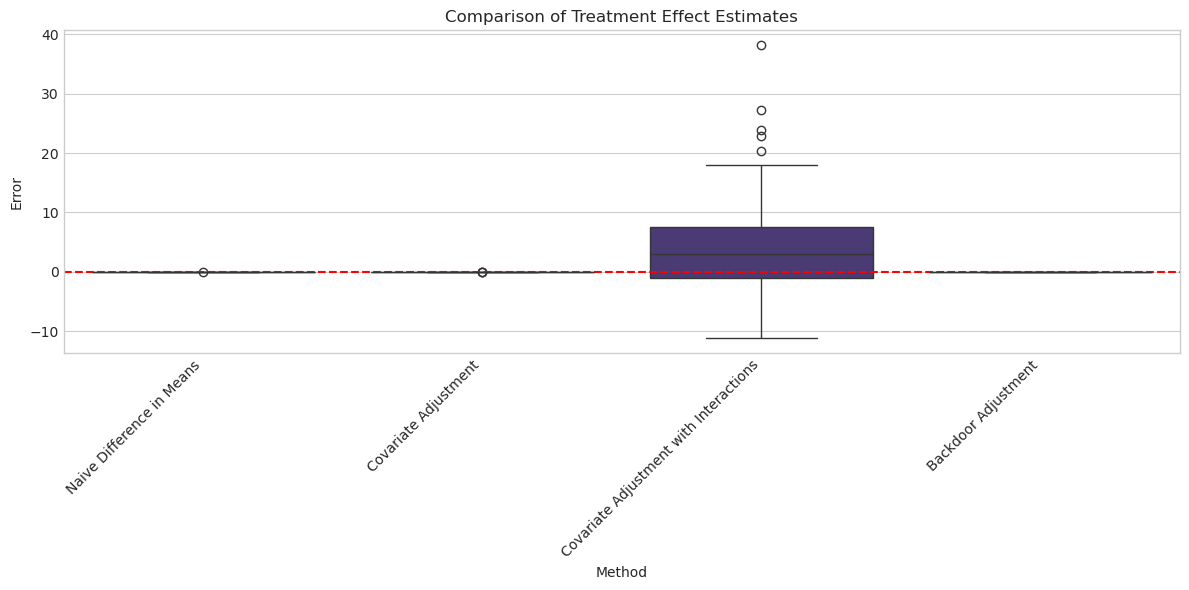

In [198]:
# Visualize the estimated vs true effects using scatter plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Method', y='Error', data=df_results)
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.title('Comparison of Treatment Effect Estimates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

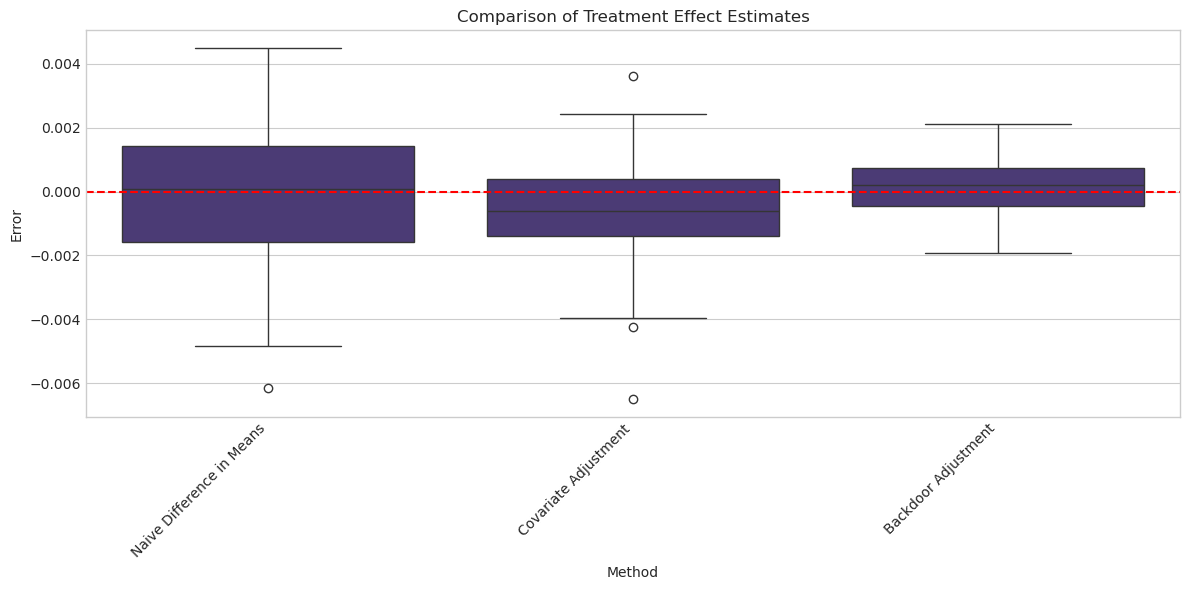

In [221]:
# Visualize the estimated vs true effects using scatter plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Method', y='Error', data=df_results[df_results['Method'] != 'Covariate Adjustment with Interactions'])
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.title('Comparison of Treatment Effect Estimates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Patient-level Treatment Effect Estimation

In [ ]:
# Calculate patient-level errors for patients in all experiments
patient_level_errors = estimate_patient_level_errors(df_experiments)


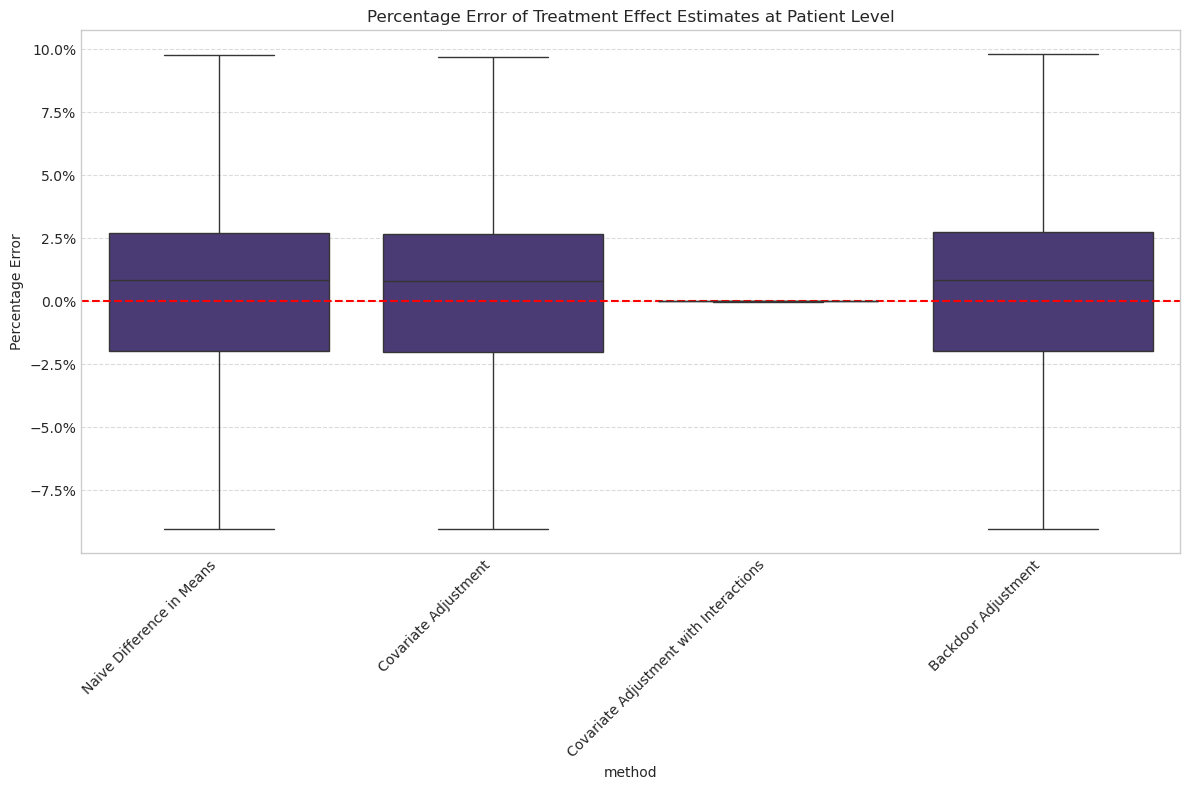

In [201]:
# Plot the results
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='method', y='percentage_error', data=patient_level_errors, showfliers=False)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Percentage Error of Treatment Effect Estimates at Patient Level')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage Error')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [204]:

# Count how often each method is closest to the true effect
patient_level_errors['Abs Error'] = patient_level_errors['percentage_error'].abs()
best_methods = patient_level_errors.loc[patient_level_errors.groupby(['patient_id'])['Abs Error'].idxmin()]
method_counts = best_methods['method'].value_counts()
print("\nCount of times each method was closest to true effect:")
print(method_counts)



Count of times each method was closest to true effect:
method
Covariate Adjustment with Interactions    19757
Naive Difference in Means                    17
Covariate Adjustment                         14
Backdoor Adjustment                          12
Name: count, dtype: int64


The covariate model is absolutely superior in assessing the patient-level treatment effects

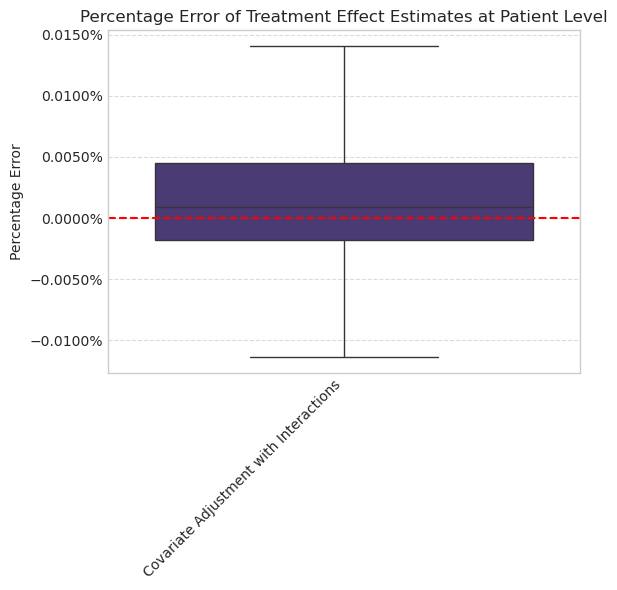

In [220]:
# Plot just the interaction method estimates
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x='method', y='percentage_error', data=patient_level_errors[patient_level_errors['method'] == 'Covariate Adjustment with Interactions'], showfliers=False)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Percentage Error of Treatment Effect Estimates at Patient Level')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('')
plt.ylabel('Percentage Error')
plt.legend()
plt.tight_layout()
plt.show()
